In [39]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from BPMN.optimization import *
torch.set_default_dtype(torch.float64)
from libSOGAtruncate import truncate
import time

['/home/rdoz/miniconda3/envs/myenv/lib/python313.zip', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/lib-dynload', '', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages', '/home/rdoz/PhD/DeGAS/src', '/home/rdoz/PhD/DeGAS/src', '/tmp/tmpgyoq5zsq', '/home/rdoz/PhD/DeGAS/src']


We consider a Business Process Simulation Model: BPSM = (W, R, D, P, T, I) where W is a WF-graph:


```mermaid
flowchart LR
    %% Order Handling WF-graph (Fig. 1)

    %% Events
    Start([Start Event])
    End([End Event])

    %% Tasks
    CCI["Collect Customer Info."]
    CEP["Collect Express Payment"]
    CSP["Collect Standard Payment"]
    PP["Prepare Package"]
    PI["Prepare Invoice"]
    SI["Send Invoice"]

    %% Gateways
    G_pay{{Payment type?}}
    G_and_split{{AND-split}}
    G_and_join{{AND-join}}

    %% Flow
    Start --> CCI
    CCI --> G_pay

    %% XOR on payment type
    G_pay -->|"Express"| CEP
    G_pay -->|"Standard"| CSP

    %% After payment, parallel branch
    CEP --> G_and_split
    CSP --> G_and_split

    %% AND-split to two parallel branches
    G_and_split --> PP
    G_and_split --> PI

    %% Invoice branch
    PI --> SI

    %% AND-join after package is ready and invoice is sent
    PP --> G_and_join
    SI --> G_and_join

    G_and_join --> End

```


R = 1; D are the distributions describing the duration of activities and are modelled with Gaussian distributions each with a specific mean and variance; P, which is a function that assigns a probability to each conditional flow is modelled with a transition matrix (in order to possibly handle also cycles).

Just for now, we neglect the waiting time distributions (T) and the interarrivals time distribution (I)

In [3]:
import torch
from torch.distributions import Normal, Categorical
import math

def simulate_bpmn(
    start_state: int,
    end_state: int,
    transition_matrix: torch.Tensor,
    duration_params: dict,
    and_splits: dict,
    join_map: dict,
    join_predecessors: dict,
    max_steps: int = 2000
):
    """
    BPMN simulator returning:
      - event log
      - flat vector of activity durations [d1, ..., dk]
      - activity_index_map = {activity_node: index}
    """

    # Map activity node -> index in the duration vector
    activity_index_map = {node: i for i, node in enumerate(duration_params.keys())}

    # Initialize the flat duration vector
    # None = activity not executed
    K = len(duration_params)
    flat_durations = [None] * K

    log = []
    current_time = 0.0

    active = [{"node": start_state, "remaining": 0.0, "start_time": current_time}]
    steps = 0

    while steps < max_steps:
        steps += 1
        if len(active) == 0:
            break

        # -----------------------------
        # Step 1: Assign durations
        # -----------------------------
        for t in active:
            node = t["node"]

            if t["remaining"] > 0:
                continue

            if node in duration_params:
                mean, std = duration_params[node]
                dur = Normal(mean, std).sample().item()
                t["remaining"] = dur
                t["start_time"] = current_time

                # record in flat vector (overwrite if multiple executions)
                idx = activity_index_map[node]
                flat_durations[idx] = dur

            else:
                # instantaneous
                t["remaining"] = 0.0
                t.setdefault("start_time", current_time)

        # -----------------------------
        # Step 2: advance time
        # -----------------------------
        min_remaining = min(t["remaining"] for t in active)
        current_time += min_remaining
        for t in active:
            t["remaining"] -= min_remaining

        # -----------------------------
        # Step 3: completed tasks
        # -----------------------------
        completed = [t for t in active if t["remaining"] <= 1e-9]

        for t in completed:
            log.append((t["node"], t["start_time"], current_time))

        for t in completed:
            active.remove(t)

        # -----------------------------
        # Step 4: successors
        # -----------------------------
        for task in completed:
            node = task["node"]

            if node == end_state:
                return log, flat_durations, activity_index_map

            # AND split
            if node in and_splits:
                for child in and_splits[node]:
                    active.append({
                        "node": child,
                        "remaining": 0.0,
                        "start_time": current_time
                    })
                continue

            # AND join
            if node in join_map:
                join_node = join_map[node]
                preds = join_predecessors[join_node]

                if all(any(ev[0] == p for ev in log) for p in preds):
                    active.append({
                        "node": join_node,
                        "remaining": 0.0,
                        "start_time": current_time
                    })
                continue

            # XOR
            probs = transition_matrix[node]
            next_node = Categorical(probs).sample().item()

            active.append({
                "node": next_node,
                "remaining": 0.0,
                "start_time": current_time
            })

    return log, flat_durations, activity_index_map


In [4]:
def simulate_n(
    n,
    start_state,
    end_state,
    transition_matrix,
    duration_params,
    and_splits,
    join_map,
    join_predecessors
):
    all_logs = []
    all_flat_durations = []
    activity_index_map = None

    for _ in range(n):
        log, flat_durations, idx_map = simulate_bpmn(
            start_state,
            end_state,
            transition_matrix,
            duration_params,
            and_splits,
            join_map,
            join_predecessors
        )

        all_logs.append(log)
        all_flat_durations.append(flat_durations)
        activity_index_map = idx_map

    return all_logs, all_flat_durations, activity_index_map


In [5]:

join_predecessors = {
    9: [6, 8]   # join node 9 waits for 6 and 8
}

join_map = {
    6: 9,
    8: 9
}

and_splits = {
    5: [6, 7]   # after split, run 6 and 7 in parallel
}


P = torch.tensor([
    #0   1   2   3    4   5   6   7   8   9   10
    [0,  1,  0,   0,   0,  0,  0,  0,  0,  0,   0],   # 0 -> 1
    [0,  0,  1,   0,   0,  0,  0,  0,  0,  0,   0],   # 1 -> 2
    [0,  0,  0, 0.4, 0.6,  0,  0,  0,  0,  0,   0],   # XOR
    [0,  0,  0,   0,   0,  1,  0,  0,  0,  0,   0],   # 3 -> 5
    [0,  0,  0,   0,   0,  1,  0,  0,  0,  0,   0],   # 4 -> 5
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   0],   # AND-split handled separately
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  1,   0],   # 6 -> join
    [0,  0,  0,   0,   0,  0,  0,  0,  1,  0,   0],   # 7 -> 8
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  1,   0],   # 8 -> join
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   1],   # 9 -> end
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   1],   # end
])

duration_params = {
    1: (2.0, 0.3),
    3: (1.0, 0.2),
    4: (3.0, 0.5),
    6: (5.0, 1.0),
    7: (4.0, 1.0),
    8: (1.0, 0.2),
}

log, flat_durations, activity_index_map = simulate_bpmn(
    start_state=0,
    end_state=10,
    transition_matrix=P,
    duration_params=duration_params,
    and_splits=and_splits,
    join_map=join_map,
    join_predecessors=join_predecessors,
    max_steps=1000
)

print(log)
print(flat_durations)
print(activity_index_map)


[(0, 0.0, 0.0), (1, 0.0, 2.3148167016554186), (2, 2.3148167016554186, 2.3148167016554186), (4, 2.3148167016554186, 5.650438398227764), (5, 5.650438398227764, 5.650438398227764), (6, 5.650438398227764, 8.649809254914015), (7, 5.650438398227764, 10.303580512627136), (8, 10.303580512627136, 11.223496653060657), (9, 11.223496653060657, 11.223496653060657), (10, 11.223496653060657, 11.223496653060657)]
[2.3148167016554186, None, 3.3356216965723453, 2.999370856686251, 4.653142114399372, 0.9199161404335205]
{1: 0, 3: 1, 4: 2, 6: 3, 7: 4, 8: 5}


In [6]:
log, flat_durations, activity_index_map = simulate_n(
    1000,
    start_state=0,
    end_state=10,
    transition_matrix=P,
    duration_params=duration_params,
    and_splits=and_splits,
    join_map=join_map,
    join_predecessors=join_predecessors
)

print(log)
print(flat_durations)
print(activity_index_map)


[[(0, 0.0, 0.0), (1, 0.0, 2.026486421412245), (2, 2.026486421412245, 2.026486421412245), (4, 2.026486421412245, 5.538821225577111), (5, 5.538821225577111, 5.538821225577111), (7, 5.538821225577111, 10.099950765757502), (8, 10.099950765757502, 11.189980493459704), (6, 5.538821225577111, 11.439796968297113), (9, 11.439796968297113, 11.439796968297113), (10, 11.439796968297113, 11.439796968297113)], [(0, 0.0, 0.0), (1, 0.0, 2.0437186915409837), (2, 2.0437186915409837, 2.0437186915409837), (3, 2.0437186915409837, 2.9903944089808974), (5, 2.9903944089808974, 2.9903944089808974), (7, 2.9903944089808974, 7.966010859588591), (6, 2.9903944089808974, 8.434154447936102), (8, 7.966010859588591, 8.893453156258428), (9, 8.893453156258428, 8.893453156258428), (10, 8.893453156258428, 8.893453156258428)], [(0, 0.0, 0.0), (1, 0.0, 1.7361604117417748), (2, 1.7361604117417748, 1.7361604117417748), (3, 1.7361604117417748, 2.5918847732812966), (5, 2.5918847732812966, 2.5918847732812966), (7, 2.5918847732812

In [7]:
def merge_activity_1_2(flat_vector):
    """
    Merge flat_vector[1] and flat_vector[2].
    Exactly one should be None.
    Returns a NEW list where index 1 = merged value and index 2 is removed.
    """
    d1 = flat_vector[1]   # activity at index 1
    d2 = flat_vector[2]   # activity at index 2

    if d1 is not None:
        merged = d1
    elif d2 is not None:
        merged = d2
    else:
        merged = None  # Should not happen (XOR branch)
    
    # new vector:
    # keep index 0 unchanged
    # assign merged to index 1
    # remove old index 2
    # keep the rest untouched

    new_vector = (
        [flat_vector[0], merged]     # index 0 and merged index 1
        + flat_vector[3:]            # skip old index 2
    )

    return new_vector


def preprocess_dataset(all_flat_durations):
    """
    Apply merge_activity_1_2 to each simulation result.
    Returns: merged dataset (list of flat vectors WITHOUT the None column)
    """
    merged_dataset = []
    for flat in all_flat_durations:
        merged_flat = merge_activity_1_2(flat)
        merged_dataset.append(merged_flat)
    return merged_dataset

# 2. Preprocess dataset (merge activities 1 and 2)
clean_durations = preprocess_dataset(flat_durations)




In [8]:
soga_code = """
array[5] tactivities;
t = 0;

/* Collect customer information */

tactivities[0] = gm([1], [_muinfo], [_sigmainfo]);
t = t + tactivities[0]; 

/* Payment */

choice = uniform([0., 1.], 2);
if choice < 0.4 {
    /* Pay electronically */
    tactivities[1] = gm([1], [_mupayE], [_sigmapayE]);
    t = t + tactivities[1];
} else {
    /* Pay standard */
    tactivities[1] = gm([1], [_mupayS], [_sigmapayS]);
    t = t + tactivities[1];
} end if;


/* Parallel activities */

tactivities[2] = gm([1], [_mupack], [_sigmapack]);
tactivities[3] = gm([1], [_muprepinv], [_sigmaprepinv]);
tactivities[4] = gm([1], [_musendinv], [_sigmasendinv]);

if tactivities[2] - tactivities[3] - tactivities[4] > 0. {
    t = t + tactivities[2];
} else {
    t = t + tactivities[3] + tactivities[4];
} end if;

"""




In [9]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,}
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

In [10]:
output_dist.gm.pi.shape[0]

8

In [11]:
y = []
y_var = []
for i in range(5):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('tactivities['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('tactivities['+ str(i) +']'), output_dist.var_list.index('tactivities['+ str(i) +']')]).detach().numpy())

output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), output_dist.var_list.index('tactivities[0]'))


tensor([[0.0051]], grad_fn=<MmBackward0>)

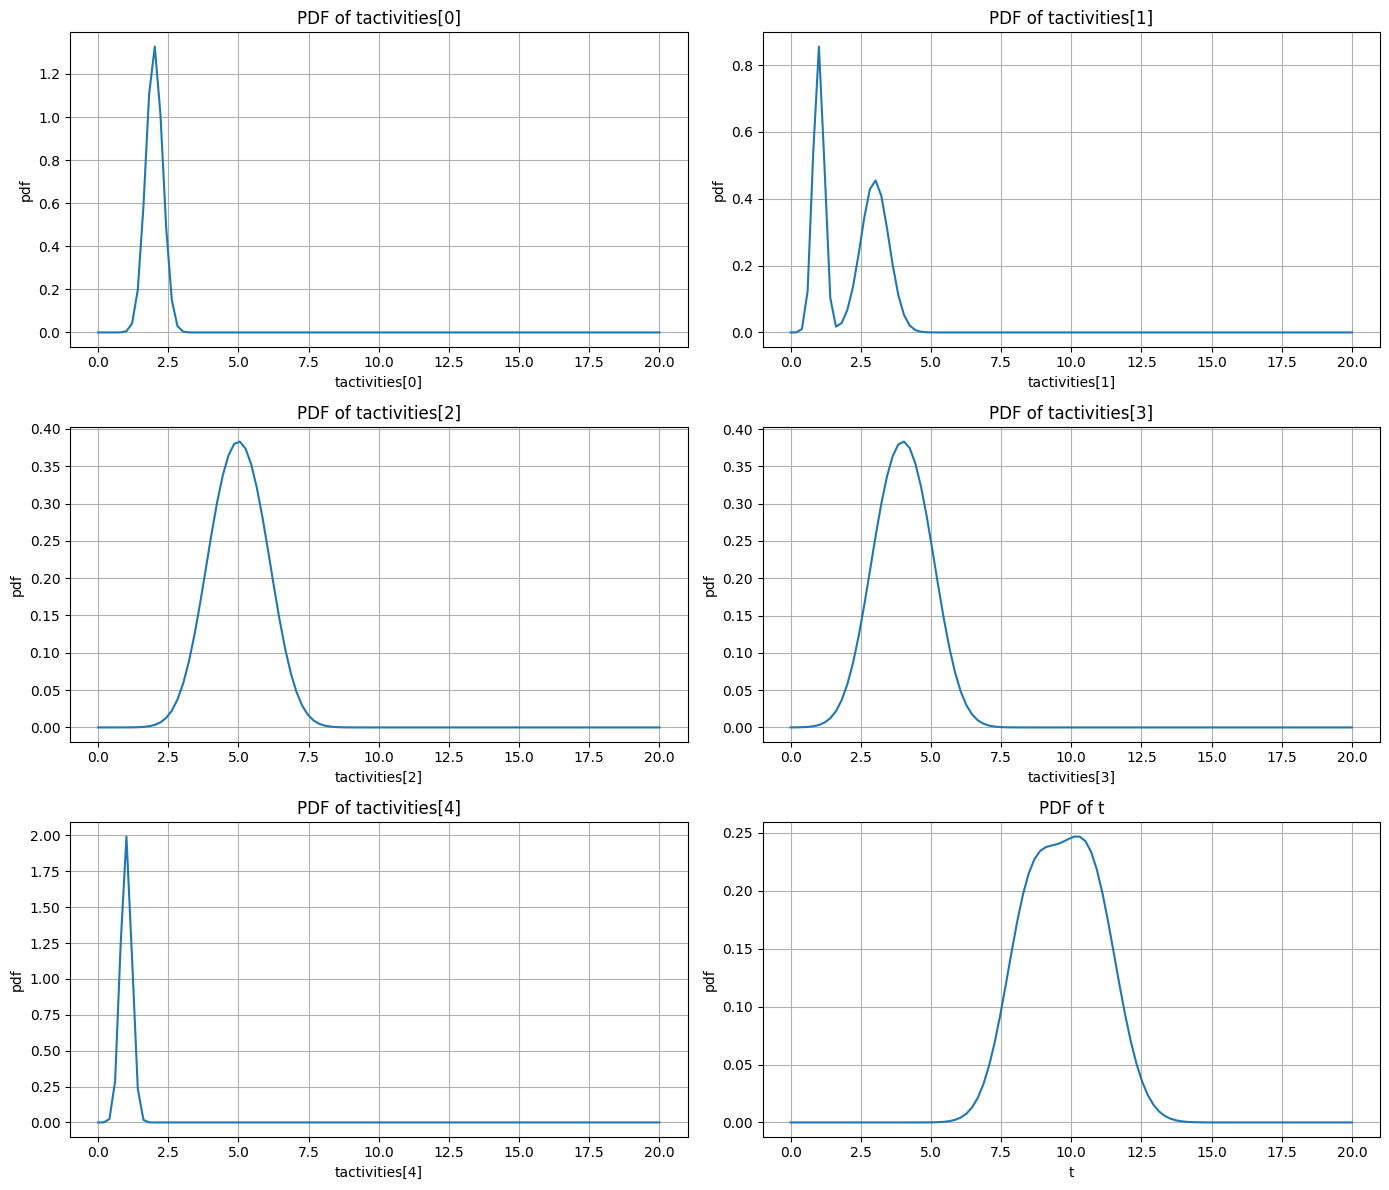

In [12]:
import torch
import matplotlib.pyplot as plt

def evaluate_marginal(output_dist, var_name, x_min, x_max, num_points=1000):
    """Evaluate marginal pdf pointwise to avoid shape mismatch issues."""
    idx = output_dist.var_list.index(var_name)
    xs = torch.linspace(x_min, x_max, num_points)

    pdf_vals = []
    for x in xs:
        # x needs to be shaped like your working call
        val = output_dist.gm.marg_pdf(x.unsqueeze(0), idx)
        pdf_vals.append(val.item())

    return xs, torch.tensor(pdf_vals)


def plot_grid_marginals(output_dist, var_names, x_min=0.0, x_max=20.0, num_points=1000):
    """Plot multiple marginal PDFs in a 3x2 grid."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, var_name in enumerate(var_names):
        xs, pdf = evaluate_marginal(output_dist, var_name, x_min, x_max, num_points)

        ax = axes[i]
        ax.plot(xs.numpy(), pdf.numpy())
        ax.set_title(f"PDF of {var_name}")
        ax.set_xlabel(var_name)
        ax.set_ylabel("pdf")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
# VARIABLES YOU WANT TO PLOT
# -----------------------------------------------------
variables_to_plot = [
    "tactivities[0]",
    "tactivities[1]",
    "tactivities[2]",
    "tactivities[3]",
    "tactivities[4]",
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)


In [13]:
def plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0,
    num_points=100
):

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    # ------------------------------------
    # Variable names for the 5 activities
    # ------------------------------------
    variable_names = [
        "tactivities[0]",
        "tactivities[1]",
        "tactivities[2]",   
        "tactivities[3]",
        "tactivities[4]",
        "t"
    ]

    # ------------------------------------
    # Plot each variable
    # ------------------------------------
    for plot_idx, var_name in enumerate(variable_names):

        ax = axes[plot_idx]

        # PDF
        xs, pdf = evaluate_marginal(output_dist, var_name, x_min, x_max, num_points)
        ax.plot(xs.numpy(), pdf.numpy(), label="PDF")
        if var_name != "t":
            # Histogram (clean_durations contains NO None now)
            vals = [run[plot_idx] for run in clean_durations if run[plot_idx] is not None]

            ax.hist(vals, bins=30, density=True, alpha=0.4)
        ax.set_title(var_name)
        ax.grid(True)

    # Empty last cell
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


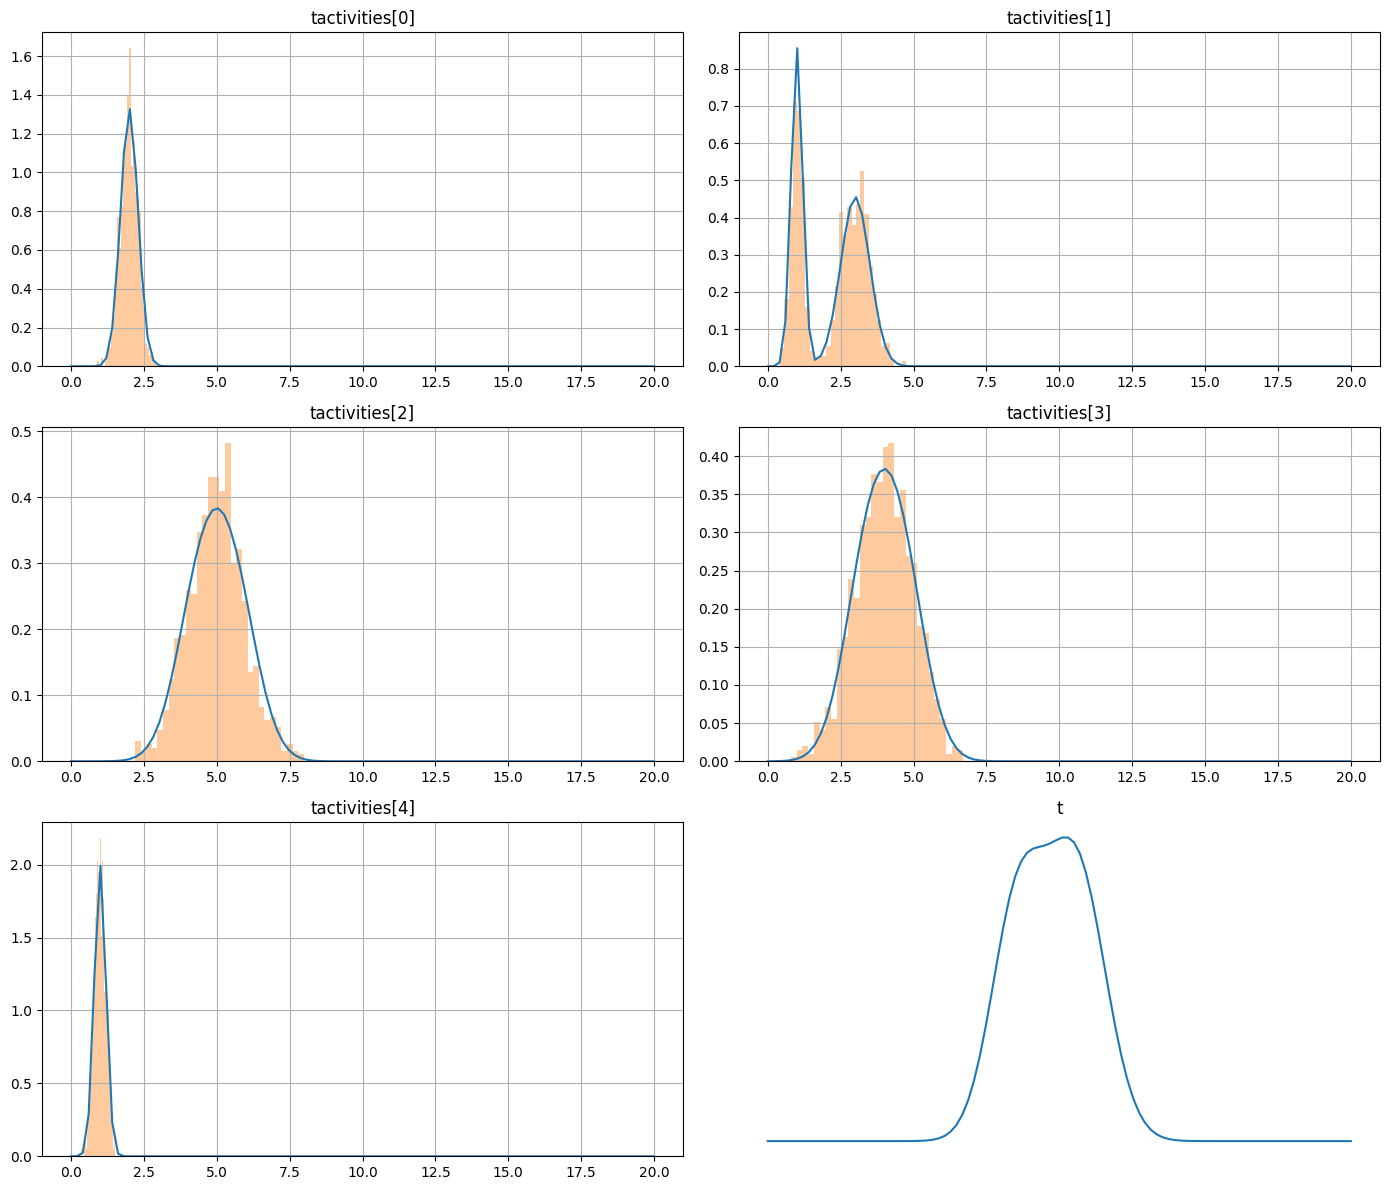

In [14]:
# 3. Plot PDFs + Histograms
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)

In [15]:
var_index = [output_dist.var_list.index('tactivities['+ str(i) +']') for i in range(5)]
neg_log_likelihood(torch.tensor(clean_durations), output_dist, var_index)

tensor(3885.9781, grad_fn=<NegBackward0>)

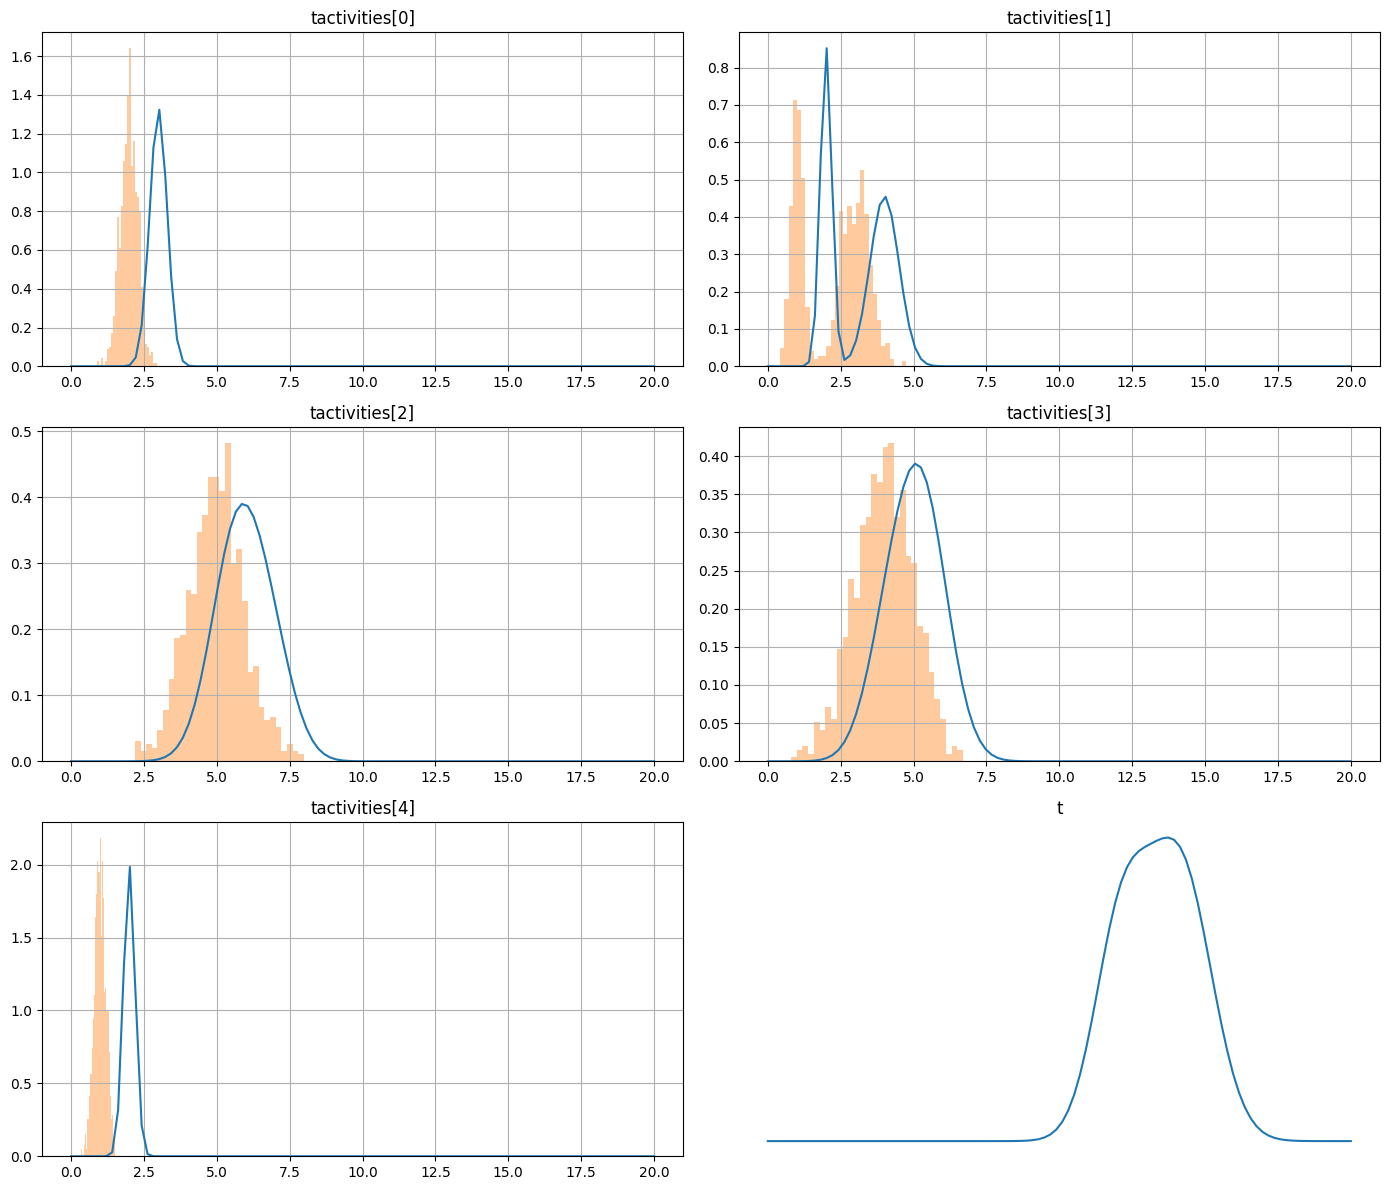

In [16]:
loss = lambda dist : neg_log_likelihood(torch.tensor(clean_durations), dist, var_index)
#add 1 to all the means
params = {'muinfo':  3., 'sigmainfo':0.3, 
          'mupayE':  2., 'sigmapayE':0.2,
          'mupayS':  4., 'sigmapayS':0.5,
          'mupack':  6., 'sigmapack':1.,
          'muprepinv':  5., 'sigmaprepinv':1.,
          'musendinv':  2., 'sigmasendinv':0.2,}

params_dict = initialize_params(params)

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)

muinfo: 2.8000000000001792 sigmainfo: 0.4999999999999465 mupayE: 1.8000000000002505 sigmapayE: 0.39999999999995717 mupayS: 3.8000000000010927 sigmapayS: 0.6999999999995087 mupack: 5.800000000002093 sigmapack: 1.199999999998278 muprepinv: 4.800000000001841 sigmaprepinv: 1.1999999999983768 musendinv: 1.8000000000000795 sigmasendinv: 0.39999999999998415  loss: 28698.412719013388
muinfo: 2.6299855917566144 sigmainfo: 0.6487368418705287 mupayE: 1.6406067587403974 sigmapayE: 0.5455345985197091 mupayS: 3.6252423595770713 sigmapayS: 0.838323108074656 mupack: 5.608799418699918 sigmapack: 1.34275638217414 muprepinv: 4.612000949271018 sigmaprepinv: 1.3469082041366514 musendinv: 1.6394149786636245 sigmasendinv: 0.5434024184428387  loss: 9367.790215712264
muinfo: 2.483195688831591 sigmainfo: 0.7646038620880765 mupayE: 1.509042308494152 sigmapayE: 0.6598704573926859 mupayS: 3.4688282954769853 sigmapayS: 0.9395732327360302 mupack: 5.429023465569988 sigmapack: 1.4225901439013178 muprepinv: 4.437728431

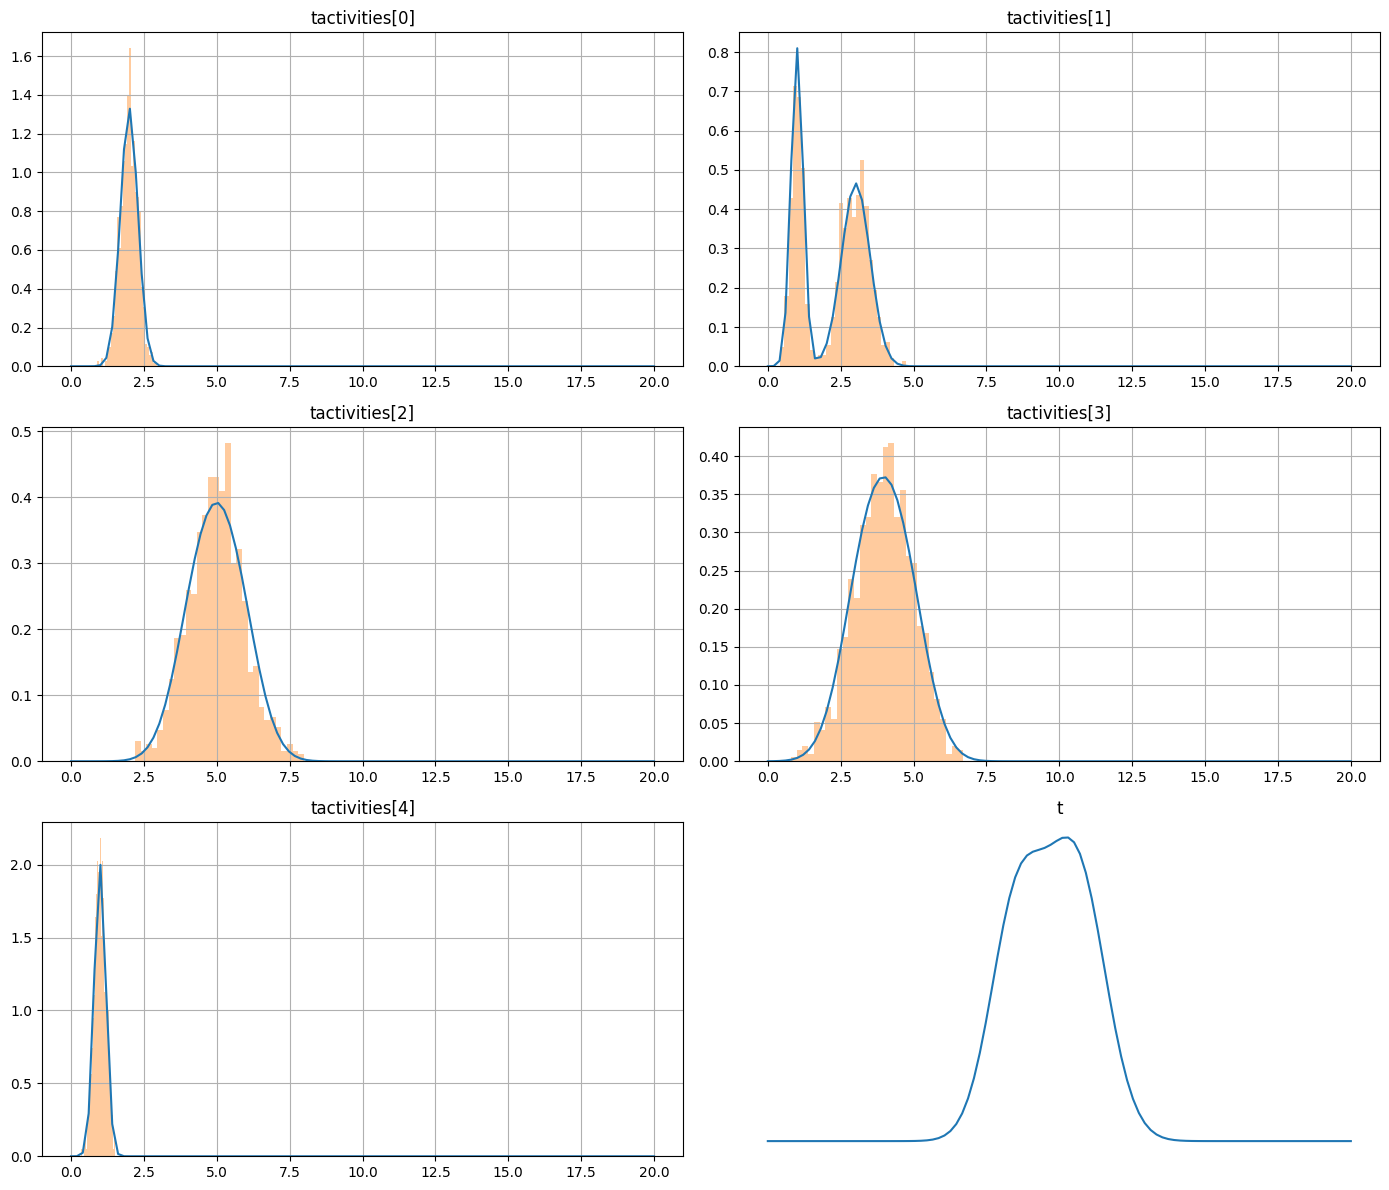

In [17]:
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=200, lr=0.2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, params_dict)
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)

## Handling resources

OPTION 1: There is a specific resource for each activity, if it is free (Bernoulli), the activity starts, otherwise there is a waiting time.

In [18]:
soga_code = """
array[5] tactivities;   
array[5] waitacts;      
array[5] startacts;     
array[5] endacts;

t = 0;

/* Resource probabilities 
   res_free_k ~ Bernoulli(p_k) means probability resource is free at activity k
*/
resinfo = bern(0.5);
respay = bern(0.8);
respack = bern(0.6);
resprep = bern(0.4);
ressend = bern(0.5);
/* Collect customer information */
waitacts[0] = gm([1], [_muwaitinfo],  [_sigmawaitinfo]);
tactivities[0] = gm([1], [_muinfo], [_sigmainfo]);

if resinfo > 0.5 {
    startacts[0] = t;
} else {
    startacts[0] = t +  waitacts[0];
} end if;
endacts[0] = startacts[0] + tactivities[0];
t = endacts[0];

if uniform([0., 1.], 2) < 0.4 {
    /* Pay electronically */
    waitacts[1]  = gm([1], [_muwaitpayE], [_sigmawaitpayE]);
    tactivities[1] = gm([1], [_mupayE], [_sigmapayE]);
} else {
    /* Pay standard */
    waitacts[1]  = gm([1], [_muwaitpayS], [_sigmawaitpayS]);
    tactivities[1] = gm([1], [_mupayS], [_sigmapayS]);
} end if;

if respay > 0.5 {
    startacts[1] = t;
} else {
    startacts[1] = t +  waitacts[1];
} end if;

endacts[1]   = startacts[1] + tactivities[1];
t = endacts[1];

/* Parallel activities */

waitacts[2]  = gm([1], [_muwaitpack],  [_sigmawaitpack]);
waitacts[3]  = gm([1], [_muwaitprep],  [_sigmawaitprep]);
waitacts[4]  = gm([1], [_muwaitsend],  [_sigmawaitsend]);

tactivities[2] = gm([1], [_mupack],    [_sigmapack]);
tactivities[3] = gm([1], [_muprepinv], [_sigmaprepinv]);
tactivities[4] = gm([1], [_musendinv], [_sigmasendinv]);

if respack > 0.5 {
        startacts[2] = t;
} else {
        startacts[2] = t +  waitacts[2];
} end if;
endacts[2] = startacts[2] + tactivities[2];

if resprep > 0.5 {
        startacts[3] = t;
} else {
        startacts[3] = t +  waitacts[3];
} end if;
endacts[3] = startacts[3] + tactivities[3];

if ressend > 0.5 {
        startacts[4] = endacts[3];
} else {
        startacts[4] = endacts[3] +  waitacts[4];
} end if;


endacts[4] = startacts[4] + tactivities[4];

/* AND join */
if endacts[2] - endacts[4] > 0. {
    t = endacts[2];
} else {
    t = endacts[4];
} end if;

"""

In [19]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,
          'muwaitinfo': 0.5, 'sigmawaitinfo':0.1,
          'muwaitpayE': 0.2, 'sigmawaitpayE':0.05,
          'muwaitpayS': 0.7, 'sigmawaitpayS':0.1,
          'muwaitpack': 1.0, 'sigmawaitpack':0.2,
          'muwaitprep': 1.5, 'sigmawaitprep':0.3,
          'muwaitsend': 0.3, 'sigmawaitsend':0.05,}
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

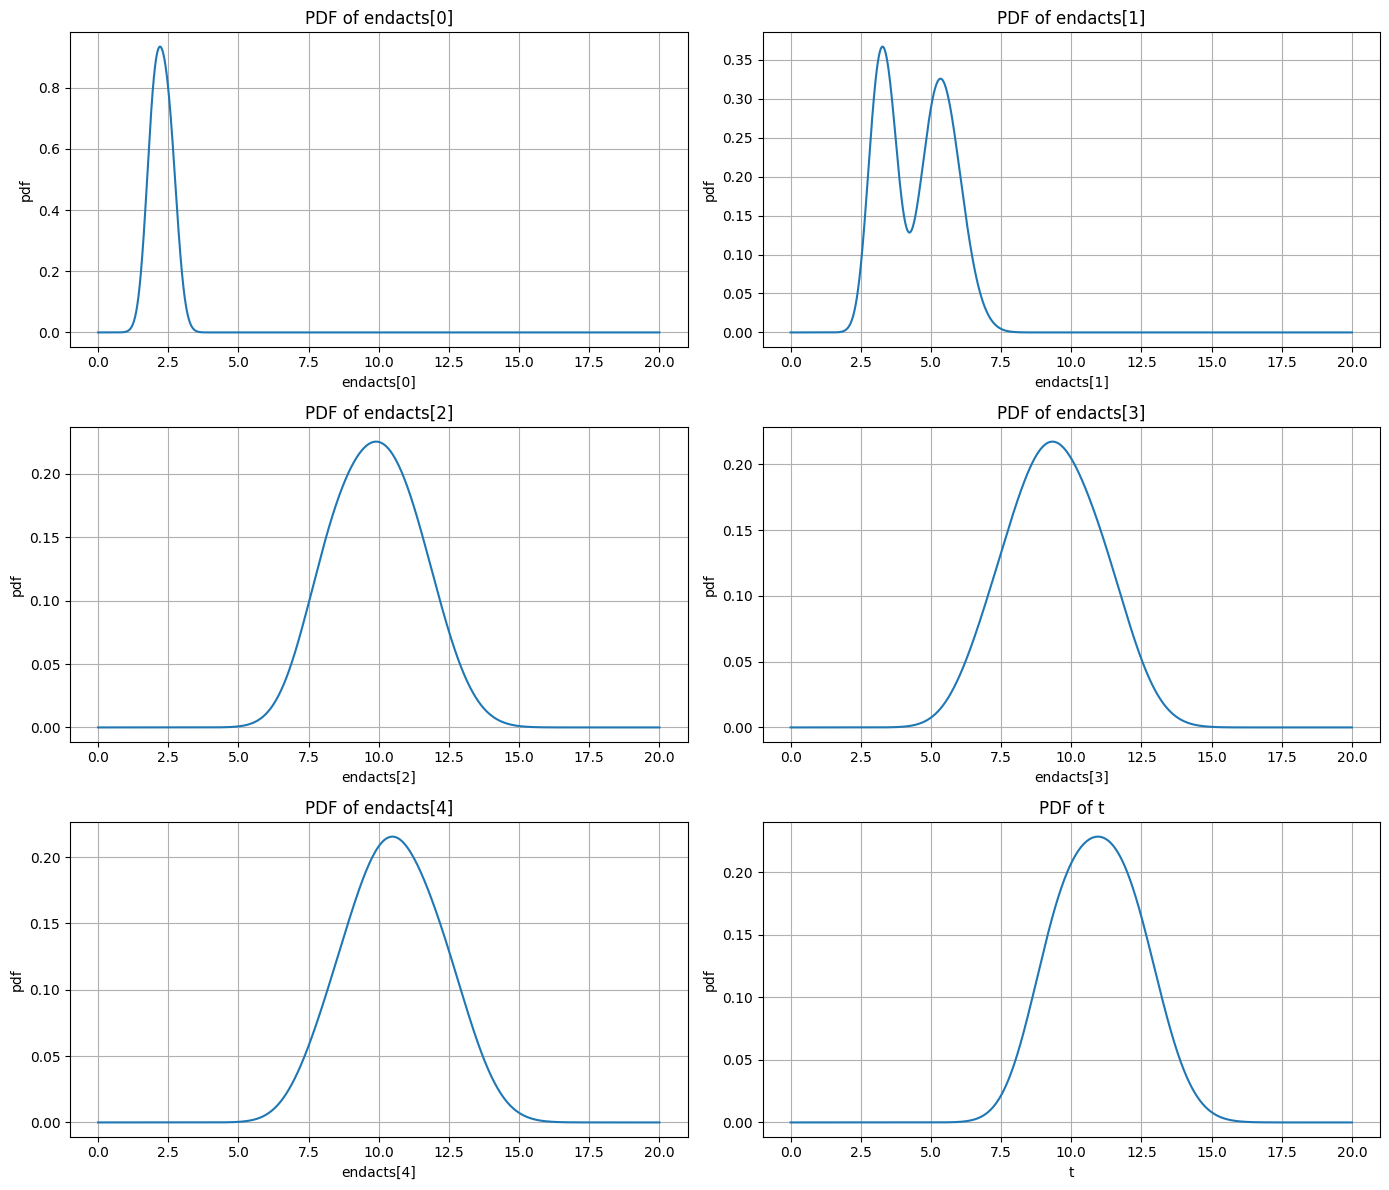

In [20]:
variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=1500)

OPTION 2: Activities share a common pool of identical resources, and the number of available resources (e.g., 1 or 2) determines how many activities can run in parallel. If more tasks become ready than available resources, they are assigned to the next free resource

In [21]:
soga_code = """
array[5] tactivities;   
array[5] waitacts;      
array[5] startacts;     
array[5] endacts;

/* Total time */
t = 0;

/* Resource capacity: either 1 or 2 (set externally) */
R = _R;    /* Allowed values: 1 or 2 */

/* =======================================================
   ACTIVITY 0 — COLLECT CUSTOMER INFORMATION (SEQUENTIAL)
   ======================================================= */

waitacts[0]     = gm([1], [_muwaitinfo],  [_sigmawaitinfo]);
tactivities[0]  = gm([1], [_muinfo], [_sigmainfo]);

/* No resource availability modelling here in Option 2,
   just start immediately in the sequential phase */
startacts[0] = t;
endacts[0]   = startacts[0] + tactivities[0];
t = endacts[0];


/* ============================
   ACTIVITY 1 — PAYMENT (XOR)
   ============================ */

if uniform([0., 1.], 2) < 0.4 {
    /* Pay electronically */
    waitacts[1]    = gm([1], [_muwaitpayE], [_sigmawaitpayE]);
    tactivities[1] = gm([1], [_mupayE],     [_sigmapayE]);
} else {
    /* Pay standard */
    waitacts[1]    = gm([1], [_muwaitpayS], [_sigmawaitpayS]);
    tactivities[1] = gm([1], [_mupayS],     [_sigmapayS]);
} end if;

/* Start immediately (no resource constraints in sequential phase) */
startacts[1] = t;
endacts[1]   = startacts[1] + tactivities[1];
t = endacts[1];


/* =====================================================
   PARALLEL BLOCK (3 ACTIVITIES): RESOURCE CAPACITY R
   ===================================================== */

/* Durations */
tactivities[2] = gm([1], [_mupack],    [_sigmapack]);
tactivities[3] = gm([1], [_muprepinv], [_sigmaprepinv]);
tactivities[4] = gm([1], [_musendinv], [_sigmasendinv]);

/* Resource loads: when each resource becomes free */
resload0 = t;
resload1 = t;    /* used only if R = 2 */


/* ---------------------------------------------
   TASK 2 — PREPARE PACKAGE
   --------------------------------------------- */

if R < 1.5 {

    startacts[2] = resload0;
    endacts[2]   = startacts[2] + tactivities[2];
    resload0     = endacts[2];

} else {

    /* choose least loaded; random tie-break */
    if resload0 - resload1 < 0. {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        startacts[2] = resload1;
        endacts[2]   = startacts[2] + tactivities[2];
        resload1     = endacts[2];

    } end if;

} end if;


/* ---------------------------------------------
   TASK 3 — PREPARE INVOICE
   --------------------------------------------- */

if R < 1.5 {

    startacts[3] = resload0;
    endacts[3]   = startacts[3] + tactivities[3];
    resload0     = endacts[3];

} else {

    if resload0 - resload1 < 0. {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        startacts[3] = resload1;
        endacts[3]   = startacts[3] + tactivities[3];
        resload1     = endacts[3];

    } end if;

} end if;


/* ---------------------------------------------
   TASK 4 — SEND INVOICE  (parallel but independent)
   --------------------------------------------- */

if R < 1.5 {

    startacts[4] = resload0;
    endacts[4]   = startacts[4] + tactivities[4];
    resload0     = endacts[4];

} else {

    if resload0 - resload1 < 0. {

        startacts[4] = resload0;
        endacts[4]   = startacts[4] + tactivities[4];
        resload0     = endacts[4];

    } else {

        startacts[4] = resload1;
        endacts[4]   = startacts[4] + tactivities[4];
        resload1     = endacts[4];

    } end if;

} end if;


/* ----------------------------
   AND JOIN: t = max(resload0, resload1)
   ---------------------------- */

if R < 1.5 {
    t = resload0;
} else {
    if resload0 - resload1 > 0. {
        t = resload0;
    } else {
        t = resload1;
    } end if;
} end if;

"""

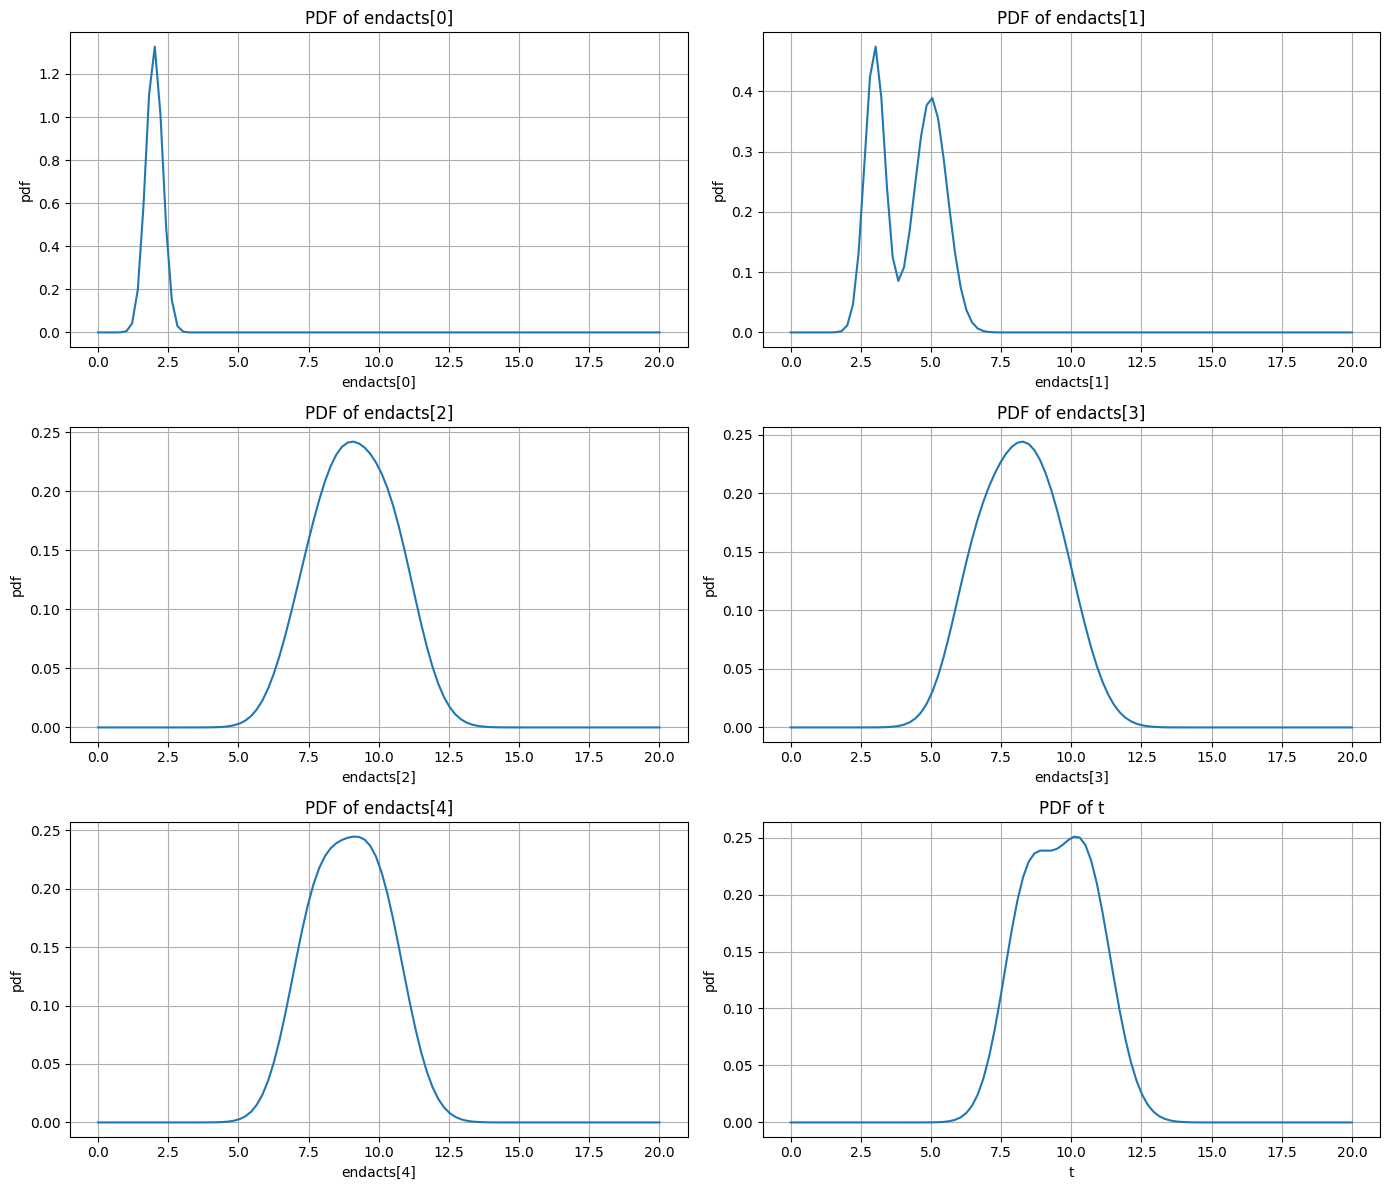

In [22]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,
          'muwaitinfo': 0.5, 'sigmawaitinfo':0.1,
          'muwaitpayE': 0.2, 'sigmawaitpayE':0.05,
          'muwaitpayS': 0.7, 'sigmawaitpayS':0.1,
          'muwaitpack': 1.0, 'sigmawaitpack':0.2,
          'muwaitprep': 1.5, 'sigmawaitprep':0.3,
          'muwaitsend': 0.3, 'sigmawaitsend':0.05,
          'R': 2.}    # resource capacity
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)

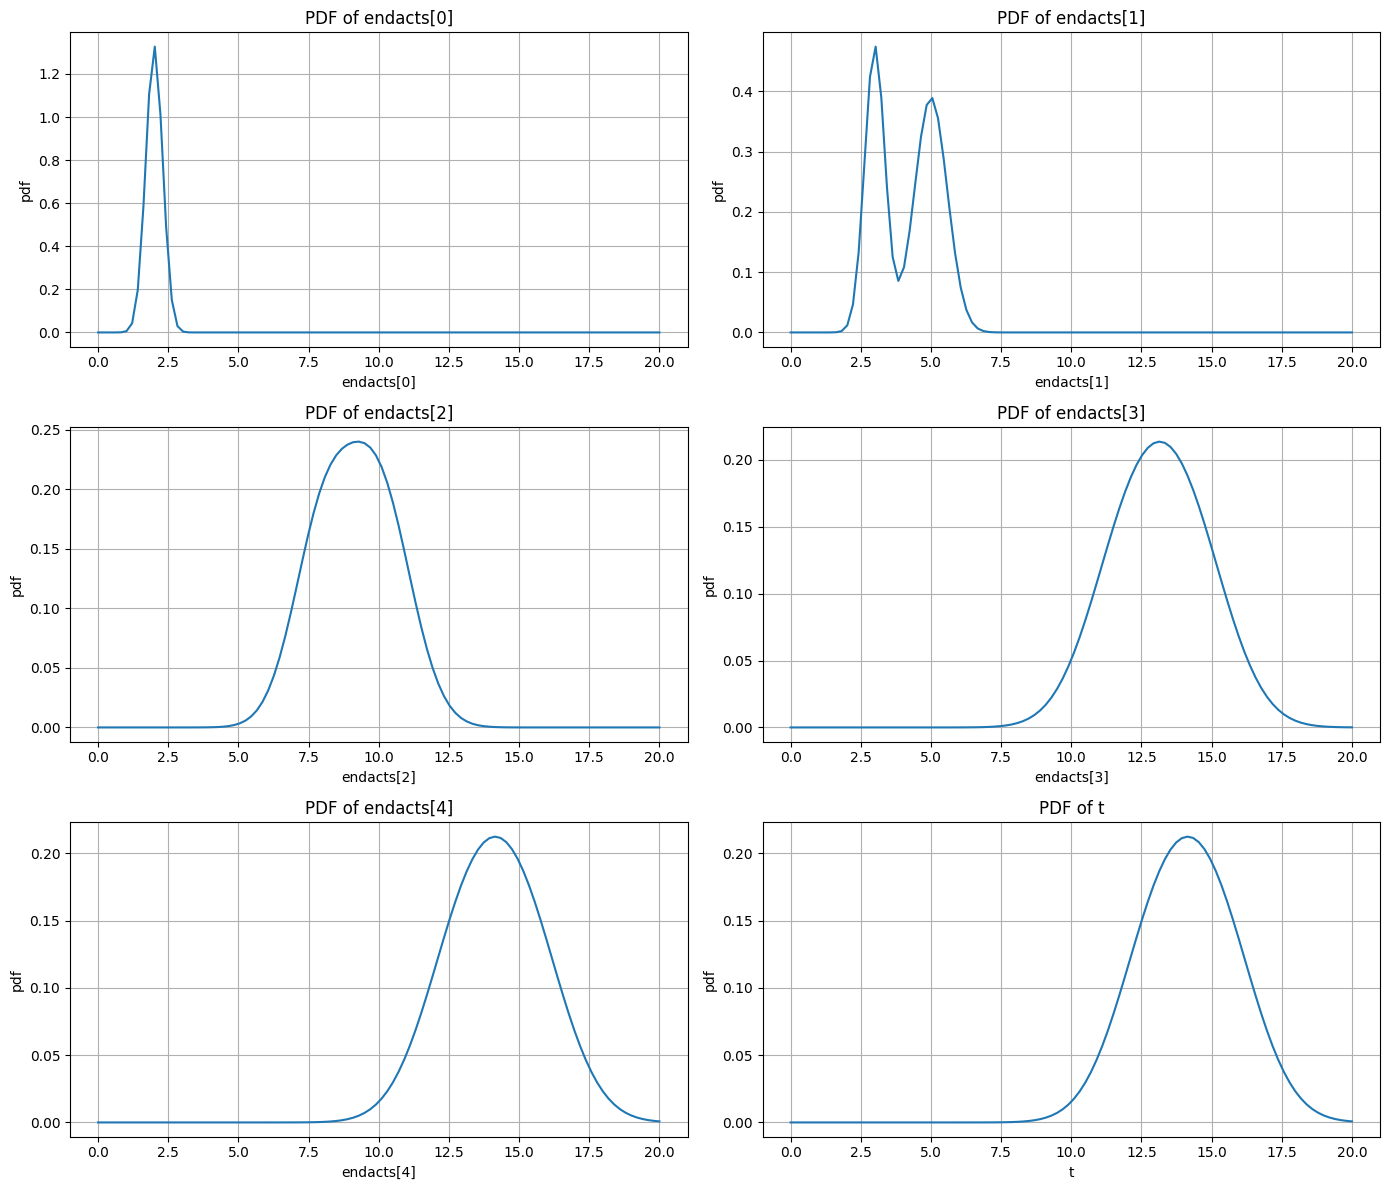

In [23]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,
          'muwaitinfo': 0.5, 'sigmawaitinfo':0.1,
          'muwaitpayE': 0.2, 'sigmawaitpayE':0.05,
          'muwaitpayS': 0.7, 'sigmawaitpayS':0.1,
          'muwaitpack': 1.0, 'sigmawaitpack':0.2,
          'muwaitprep': 1.5, 'sigmawaitprep':0.3,
          'muwaitsend': 0.3, 'sigmawaitsend':0.05,
          'R': 1.}    # resource capacity
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)

Fix the fact that send invoice cannot start before prepare invoince finishes

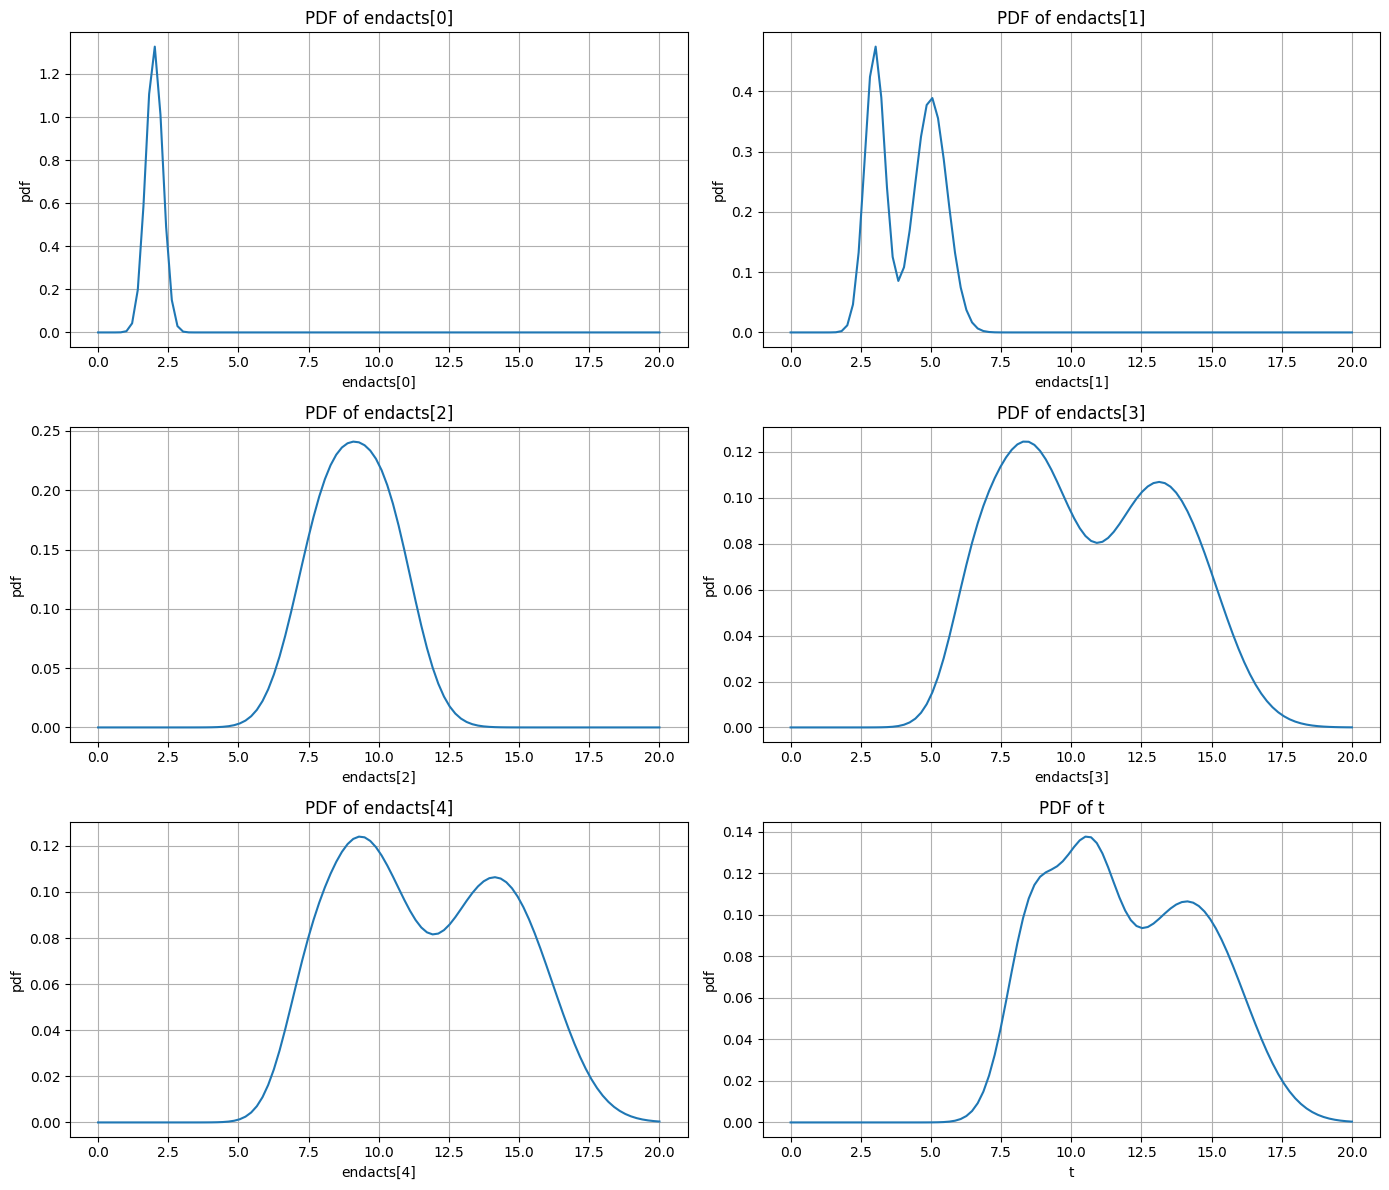

In [24]:
soga_code = """
array[5] tactivities;   
array[5] waitacts;      
array[5] startacts;     
array[5] endacts;

/* Total time */
t = 0;

/* Resource capacity: either 1 or 2 (set externally) */
R = 1 + bern(0.5);    /* Allowed values: 1 or 2 */

/* =======================================================
   ACTIVITY 0 — COLLECT CUSTOMER INFORMATION (SEQUENTIAL)
   ======================================================= */

waitacts[0]     = gm([1], [_muwaitinfo],  [_sigmawaitinfo]);
tactivities[0]  = gm([1], [_muinfo], [_sigmainfo]);

/* No resource availability modelling here in Option 2,
   just start immediately in the sequential phase */
startacts[0] = t;
endacts[0]   = startacts[0] + tactivities[0];
t = endacts[0];


/* ============================
   ACTIVITY 1 — PAYMENT (XOR)
   ============================ */

if uniform([0., 1.], 2) < 0.4 {
    /* Pay electronically */
    waitacts[1]    = gm([1], [_muwaitpayE], [_sigmawaitpayE]);
    tactivities[1] = gm([1], [_mupayE],     [_sigmapayE]);
} else {
    /* Pay standard */
    waitacts[1]    = gm([1], [_muwaitpayS], [_sigmawaitpayS]);
    tactivities[1] = gm([1], [_mupayS],     [_sigmapayS]);
} end if;

/* Start immediately (no resource constraints in sequential phase) */
startacts[1] = t;
endacts[1]   = startacts[1] + tactivities[1];
t = endacts[1];


/* =====================================================
   PARALLEL BLOCK (3 ACTIVITIES): RESOURCE CAPACITY R
   ===================================================== */

/* Durations */
tactivities[2] = gm([1], [_mupack],    [_sigmapack]);
tactivities[3] = gm([1], [_muprepinv], [_sigmaprepinv]);
tactivities[4] = gm([1], [_musendinv], [_sigmasendinv]);

/* Resource loads: when each resource becomes free */
resload0 = t;
resload1 = t;    /* used only if R = 2 */


/* ---------------------------------------------
   TASK 2 — PREPARE PACKAGE
   --------------------------------------------- */

if R < 1.5 {

    startacts[2] = resload0;
    endacts[2]   = startacts[2] + tactivities[2];
    resload0     = endacts[2];

} else {

    /* choose least loaded; random tie-break */
    if resload0 - resload1 < 0. {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        startacts[2] = resload1;
        endacts[2]   = startacts[2] + tactivities[2];
        resload1     = endacts[2];

    } end if;

} end if;


/* ---------------------------------------------
   TASK 3 — PREPARE INVOICE
   --------------------------------------------- */

if R < 1.5 {

    startacts[3] = resload0;
    endacts[3]   = startacts[3] + tactivities[3];
    resload0     = endacts[3];

} else {

    if resload0 - resload1 < 0. {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        startacts[3] = resload1;
        endacts[3]   = startacts[3] + tactivities[3];
        resload1     = endacts[3];

    } end if;

} end if;


/* ---------------------------------------------
   TASK 4 — SEND INVOICE  (parallel but independent)
   --------------------------------------------- */

ready4 = endacts[3];   /* Task 4 can start only after Task 3 finishes */

if R < 1.5 {

    /* single resource */
    if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
    endacts[4] = startacts[4] + tactivities[4];
    resload0   = endacts[4];

} else {

    /* two resources: choose least loaded, but also respect ready4 */
    if resload0 - resload1 < 0. {

        if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload0   = endacts[4];

    } else {

        if resload1 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload1; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload1   = endacts[4];

    } end if;

} end if;



/* ----------------------------
   AND JOIN: t = max(resload0, resload1)
   ---------------------------- */

if R < 1.5 {
    t = resload0;
} else {
    if resload0 - resload1 > 0. {
        t = resload0;
    } else {
        t = resload1;
    } end if;
} end if;

"""

# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,
          'muwaitinfo': 0.5, 'sigmawaitinfo':0.1,
          'muwaitpayE': 0.2, 'sigmawaitpayE':0.05,
          'muwaitpayS': 0.7, 'sigmawaitpayS':0.1,
          'muwaitpack': 1.0, 'sigmawaitpack':0.2,
          'muwaitprep': 1.5, 'sigmawaitprep':0.3,
          'muwaitsend': 0.3, 'sigmawaitsend':0.05}
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)

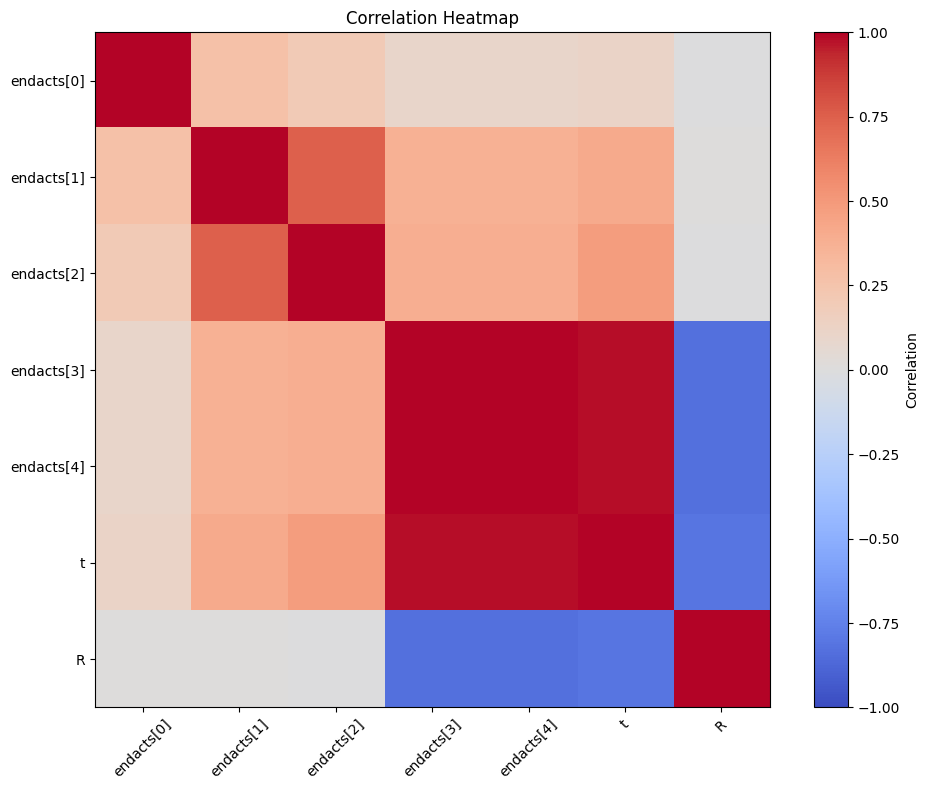

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_heatmap(output_dist, selected_vars):
    gm = output_dist.gm
    all_vars = output_dist.var_list

    # ---- normalize weights: fix shape (48,1) → (48,) ----
    w = gm.pi.squeeze()
    w = w / w.sum()
    K = w.shape[0]

    # ---- get indices for selected variables ----
    idx = [all_vars.index(v) for v in selected_vars]
    d   = len(idx)

    # ---- extract mixture means and covariances ----
    means = gm.mu[:, idx]                 # (48, d)
    covs  = gm.sigma[:, idx][:, :, idx]   # (48, d, d)

    # ---- global mean ----
    mu = torch.sum(w[:, None] * means, dim=0)    # (d,)

    # ---- between-component covariance ----
    diffs = means - mu[None, :]                  # (48, d)
    outer = diffs[:, :, None] * diffs[:, None, :]  # (48, d, d)

    # ---- global covariance ----
    Sigma = torch.sum(w[:, None, None] * (covs + outer), dim=0)  # (d, d)

    # ---- correlation matrix ----
    diag = torch.sqrt(torch.diag(Sigma))
    corr = Sigma / (diag[:, None] * diag[None, :])
    corr = corr.cpu().detach().numpy()

    # ---- plot ----
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")

    plt.xticks(range(d), selected_vars, rotation=45)
    plt.yticks(range(d), selected_vars)

    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()


selected = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]",
    "t",
    "R",
]

plot_correlation_heatmap(output_dist, selected)


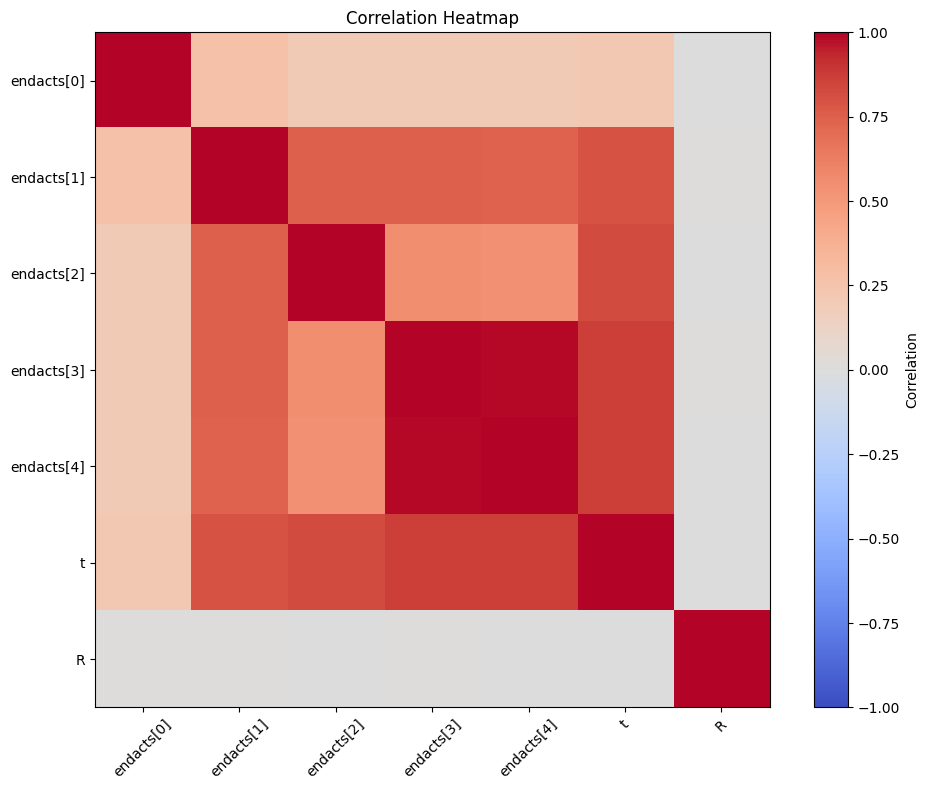

In [26]:
# compute conditionals
factors, truncated_dist = truncate(output_dist, 'R > 1.5', {},{})
plot_correlation_heatmap(truncated_dist, selected)

In [27]:
print(output_dist.gm.mean())
print(truncated_dist.gm.mean())
print(output_dist.var_list)

tensor([ 2.0000e+00,  2.1416e+00,  5.0000e+00,  4.0000e+00,  1.0000e+00,
         5.0000e-01,  4.8541e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -8.8718e-31,  2.0000e+00,  4.1414e+00,  6.6419e+00,  1.0647e+01,
         2.0000e+00,  4.1416e+00,  9.1414e+00,  1.0642e+01,  1.1647e+01,
         1.1941e+01,  1.5000e+00,  1.1694e+01,  6.6940e+00,  1.0642e+01],
       grad_fn=<SumBackward1>)
tensor([ 2.0000e+00,  2.1416e+00,  5.0000e+00,  4.0000e+00,  1.0000e+00,
         5.0000e-01,  4.8541e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.7744e-30,  2.0000e+00,  4.1411e+00,  4.1422e+00,  8.1517e+00,
         2.0000e+00,  4.1416e+00,  9.1411e+00,  8.1422e+00,  9.1517e+00,
         9.7392e+00,  2.0000e+00,  9.2464e+00,  9.2464e+00,  8.1422e+00],
       grad_fn=<SumBackward1>)
['tactivities[0]', 'tactivities[1]', 'tactivities[2]', 'tactivities[3]', 'tactivities[4]', 'waitacts[0]', 'waitacts[1]', 'waitacts[2]', 'waitacts[3]', 'waitacts[4]', 'startacts[0]', 'startacts[1]', 'startac

Consider that we can have 2 before 3 or 3 before 2

Execution time: 0.20627284049987793 seconds


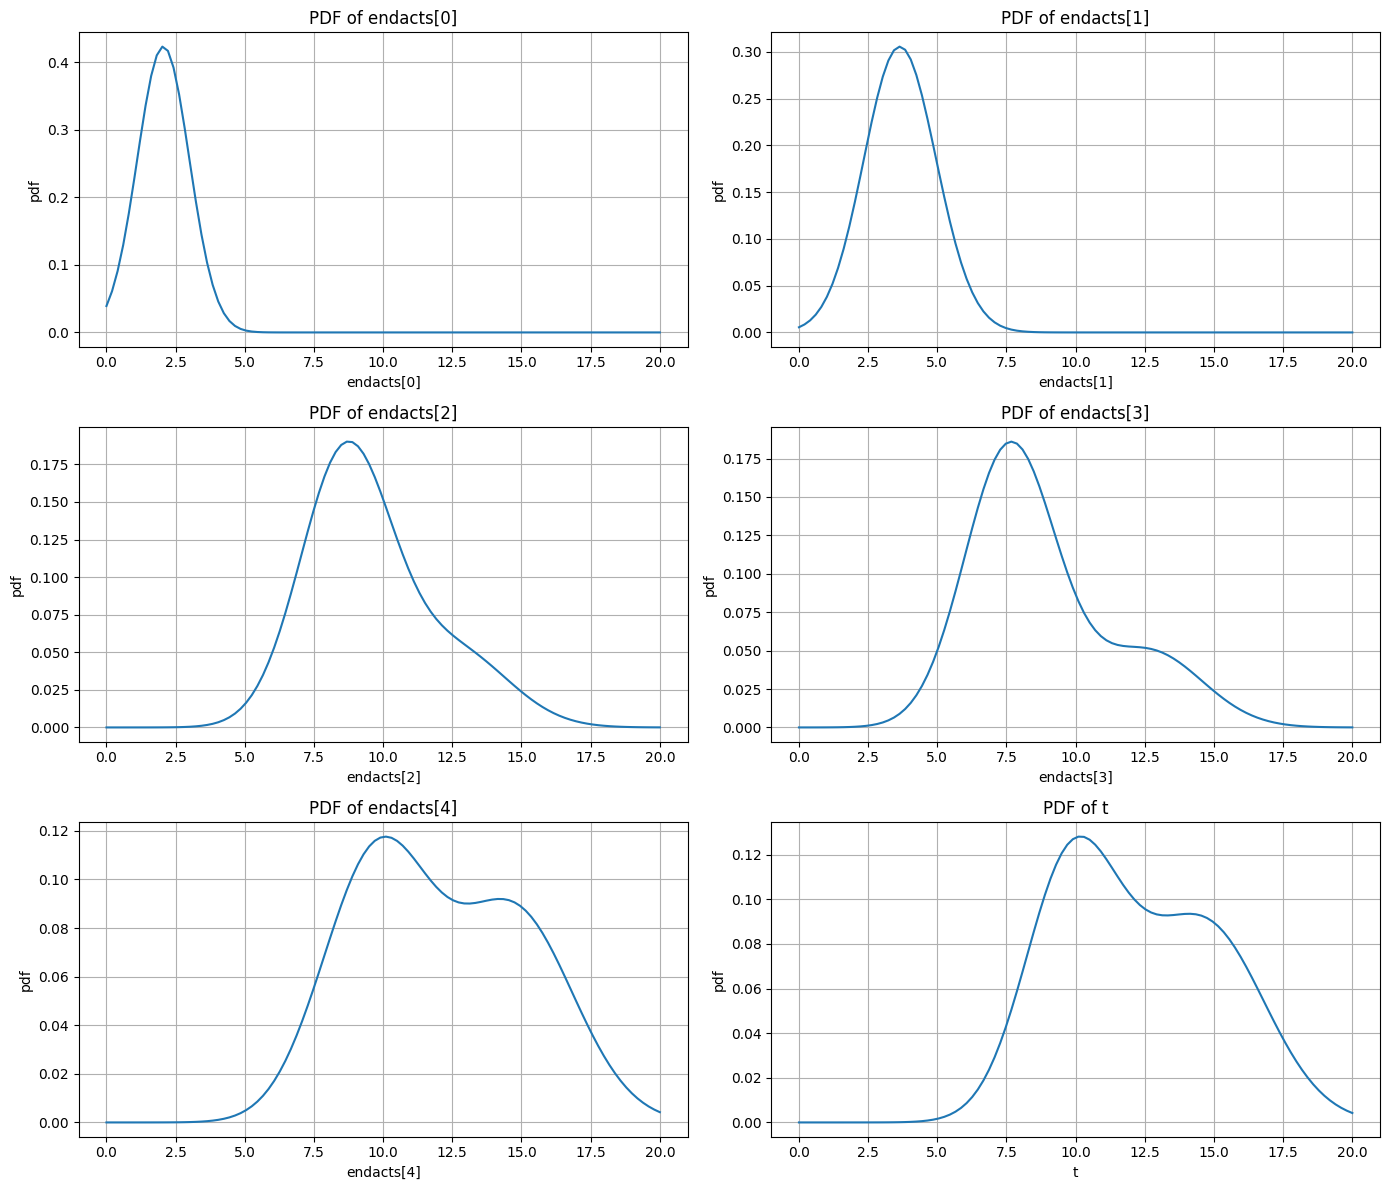

tensor([[0.1017]], grad_fn=<MmBackward0>)


In [65]:
soga_code = """
array[5] tactivities;    
array[5] startacts;     
array[5] endacts;

/* Total time */
t = 0;

/* Resource capacity: either 1 or 2 (set externally) */
resourcerate2 = _resourcesrate * _resourcesrate;
R = 1 +  resourcerate2;    /* Allowed values: 1 or 2 */

/* =======================================================
   ACTIVITY 0 — COLLECT CUSTOMER INFORMATION (SEQUENTIAL)
   ======================================================= */

tactivities[0]  = _muinfo*_muinfo + gm([1], [0.], [1.]);
observe(tactivities[0] > 0.);  /* ensure positive durations */

/* No resource availability modelling here in Option 2,
   just start immediately in the sequential phase */
startacts[0] = t;
endacts[0]   = startacts[0] + tactivities[0];
t = endacts[0];


/* ============================
   ACTIVITY 1 — PAYMENT (XOR)
   ============================ */

switch2 = _switch * _switch;
   
if uniform([0., 1.], 2) - switch2 < 0. {
    /* Pay electronically */
    tactivities[1] = gm([1], [_mupayE],     [1.]);
} else {
    /* Pay standard */
    tactivities[1] = gm([1], [_mupayS],     [1.]);
} end if;

observe(tactivities[1] > 0.);  /* ensure positive durations */
/* Start immediately (no resource constraints in sequential phase) */
startacts[1] = t;
endacts[1]   = startacts[1] + tactivities[1];
t = endacts[1];


/* =====================================================
   PARALLEL BLOCK (3 ACTIVITIES): RESOURCE CAPACITY R
   ===================================================== */

/* Durations */
tactivities[2] = _mupack * _mupack + gm([1], [0.],    [1.]);
tactivities[3] = _muprepinv * _muprepinv + gm([1], [0.], [1.]);
tactivities[4] = _musendinv * _musendinv + gm([1], [0.], [1.]);
observe(tactivities[2] > 0.);  /* ensure positive durations */
observe(tactivities[3] > 0.);  /* ensure positive durations */
observe(tactivities[4] > 0.);  /* ensure positive durations */

/* Resource loads: when each resource becomes free */
resload0 = t;
resload1 = t;    /* used only if R = 2 */


/* ---------------------------------------------
   CASE TASK 2 (PREPARE PACKAGE) COMES BEFORE TASK 3 (PREPARE INVOICE)
   --------------------------------------------- */
if uniform([0., 1.], 2) < 0.5 {
    if R < 1.5 {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        /* choose least loaded; random tie-break */
        if resload0 - resload1 < 0. {

            startacts[2] = resload0;
            endacts[2]   = startacts[2] + tactivities[2];
            resload0     = endacts[2];

        } else {

            startacts[2] = resload1;
            endacts[2]   = startacts[2] + tactivities[2];
            resload1     = endacts[2];

        } end if;

    } end if;


    /* ---------------------------------------------
    TASK 3 — PREPARE INVOICE
    --------------------------------------------- */

    if R < 1.5 {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        if resload0 - resload1 < 0. {

            startacts[3] = resload0;
            endacts[3]   = startacts[3] + tactivities[3];
            resload0     = endacts[3];

        } else {

            startacts[3] = resload1;
            endacts[3]   = startacts[3] + tactivities[3];
            resload1     = endacts[3];

        } end if;

    } end if;
} else {
/* ---------------------------------------------
    TASK 3 — PREPARE INVOICE
    --------------------------------------------- */

    if R < 1.5 {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        if resload0 - resload1 < 0. {

            startacts[3] = resload0;
            endacts[3]   = startacts[3] + tactivities[3];
            resload0     = endacts[3];

        } else {

            startacts[3] = resload1;
            endacts[3]   = startacts[3] + tactivities[3];
            resload1     = endacts[3];

        } end if;

    } end if;

    if R < 1.5 {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        /* choose least loaded; random tie-break */
        if resload0 - resload1 < 0. {

            startacts[2] = resload0;
            endacts[2]   = startacts[2] + tactivities[2];
            resload0     = endacts[2];

        } else {

            startacts[2] = resload1;
            endacts[2]   = startacts[2] + tactivities[2];
            resload1     = endacts[2];

        } end if;

    } end if;
} end if;



/* ---------------------------------------------
   TASK 4 — SEND INVOICE
   --------------------------------------------- */

ready4 = endacts[3];   /* Task 4 can start only after Task 3 finishes */

if R < 1.5 {

    /* single resource */
    if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
    endacts[4] = startacts[4] + tactivities[4];
    resload0   = endacts[4];

} else {

    /* two resources: choose least loaded, but also respect ready4 */
    if resload0 - resload1 < 0. {

        if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload0   = endacts[4];

    } else {

        if resload1 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload1; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload1   = endacts[4];

    } end if;

} end if;



/* ----------------------------
   AND JOIN: t = max(resload0, resload1)
   ---------------------------- */

if R < 1.5 {
    t = resload0;
} else {
    if resload0 - resload1 > 0. {
        t = resload0;
    } else {
        t = resload1;
    } end if;
} end if;

"""

# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

#square root all parameters to ensure positivity
for key in params:
    params[key] = params[key]**0.5
    
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
#measure execution time

start_time = time.time()

output_dist = start_SOGA(cfg, params_dict) 

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)
print(output_dist.gm.marg_pdf(torch.tensor([12.]), output_dist.var_list.index('t')))

In [72]:
loss = lambda output_dist: -output_dist.gm.marg_pdf(torch.tensor([9.]), output_dist.var_list.index('t'))
# avoid optimizing mupack by setting to false the requires_grad flag
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

print("Initial parameters:")
# print params
for key, value in params.items():
    print(f"{key}: {value}")


for key in params:
    params[key] = params[key]**0.5

params_dict = initialize_params(params) 

#params_dict['mupack'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['musendinv'].requires_grad = False

#params_dict['mupayE'].requires_grad = False
#params_dict['mupayS'].requires_grad = False
#params_dict['switch'].requires_grad = False

start_time = time.time()
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=100, lr=0.01)

end_time = time.time()
execution_time = end_time - start_time
print(f"Optimization execution time: {execution_time} seconds")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, params_dict)
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)

for key in params:
    params[key] = params[key]**2

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")


Initial parameters:
muinfo: 2.0
mupayE: 1.0
mupayS: 3.0
mupack: 5.0
muprepinv: 4.0
musendinv: 2.0
resourcesrate: 0.5
switch: 0.4


muinfo: 1.4042135634201385 mupayE: 0.9900000127908595 mupayS: 1.7220508122171323 mupack: 2.2260679800300056 muprepinv: 1.9900000008234782 musendinv: 1.4042135636073914 resourcesrate: 0.7171067811855556 switch: 0.6424555277536895  loss: -0.1060980724968885
muinfo: 1.3943953953069272 mupayE: 0.9801733674823473 mupayS: 1.7122766248114538 mupack: 2.2161956003550087 muprepinv: 1.9801900375441264 musendinv: 1.3943954740035798 resourcesrate: 0.7238073637259808 switch: 0.652291787419824  loss: -0.2066185891547903
muinfo: 1.384479365515758 mupayE: 0.9702528628496211 mupayS: 1.7023832073325145 mupack: 2.2066648089986405 muprepinv: 1.9702765636577468 musendinv: 1.3844769106753128 resourcesrate: 0.7289869334499433 switch: 0.6622124933794058  loss: -0.21251653805760284
muinfo: 1.3745478241714197 mupayE: 0.9603245915176175 mupayS: 1.6924449524811007 mupack: 2.1978214301853 muprepinv: 1.960332954787769 musendinv: 1.3745265444911516 resourcesrate: 0.7332297218006967 switch: 0.6721236683198477  loss: -

KeyboardInterrupt: 

In [30]:
loss = lambda dist : neg_log_likelihood(torch.tensor(clean_durations), dist, var_index)
